In [15]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from matplotlib.colors import Colormap
from matplotlib.image import AxesImage
from PIL import Image, ImageOps
from sklearn import preprocessing as prep

from module.conf import PROJECT_DIR

# matplotlib.use("QTCairo")

## 1. Read Image

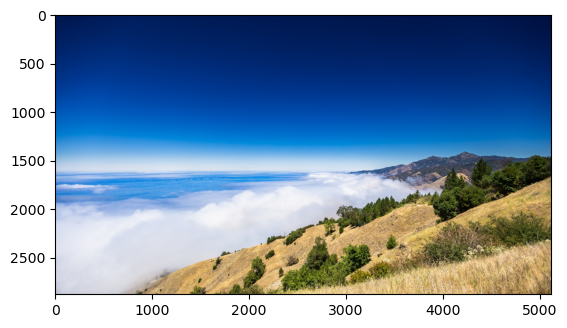

In [16]:
with Image.open(fp=PROJECT_DIR + "/data/img/BigSur.jpg") as img:
    mImg = np.asarray(img)
    fig, axes = plt.subplots()
    axes.imshow(mImg)
    plt.show()

## 2. Write Image:

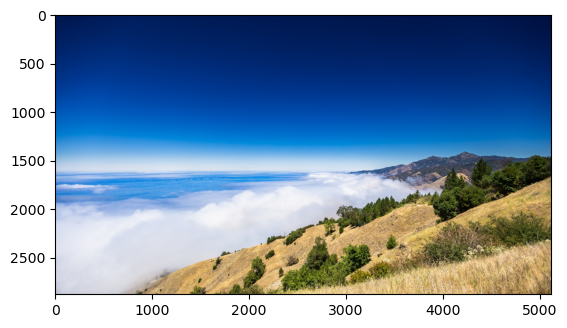

In [17]:
# mImg.save(fp=PROJECT_DIR + "/data/img/Cyprus_1.jpg")

fig, axes = plt.subplots()
axes.imshow(mImg)
plt.show()

## 3. Process Image

### 3.1 Re-Scale Image colors:

result: True


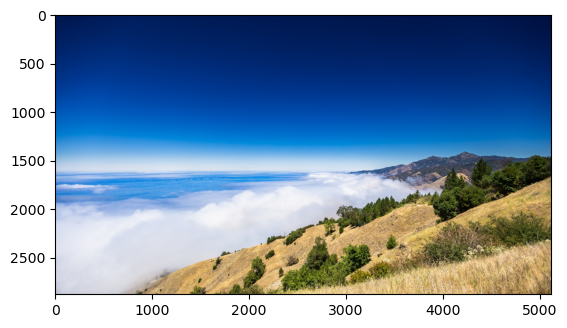

In [18]:
# min = np.min(a=mImg, axis=2)
# max = np.max(a=mImg, axis=2)
# print(f"{mImg[:,:,0].shape} {(max - min).shape}")
# mImgRescaled = np.zeros(shape=mImg.shape)
# mImgRescaled[:,:,0] = (mImg[:,:,0] - min)/(max - min)
# mImgRescaled[:,:,1] = (mImg[:,:,1] - min)/(max - min)
# mImgRescaled[:,:,2] = (mImg[:,:,2] - min)/(max - min)
mImgRescaled = mImg/255
# print(mImgRescaled)
# mImgRescaled = prep.StandardScaler().fit(mImg)

mImgRestored = np.dot(mImgRescaled, 255).astype(np.uint8)
modImg: Image.Image = Image.fromarray(mImgRestored)
print(f"result: {np.array_equal(mImg, mImgRestored)}")
fig, axes = plt.subplots()
axes.imshow(modImg)
plt.show()

### 3.2 Gray scale

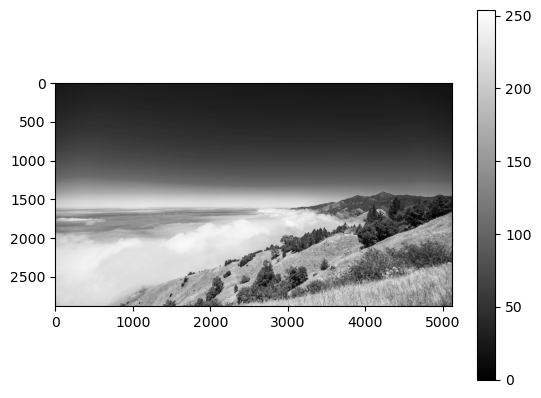

In [19]:
# modImg = ImageOps.grayscale(img)
# mImgGrayScale1 = np.asarray(modImg)
mImgGrayScale = np.zeros(mImg.shape)
R = mImg[:, :, 0].astype(np.uint16)
G = mImg[:, :, 1].astype(np.uint16)
B = mImg[:, :, 2].astype(np.uint16)
# mImgGrayScale = (R * .25 + G * .625 + B*.125).astype(np.uint8)
mImgGrayScale = ((R * 2 + G * 5 + B)/8).astype(np.uint8)
# print(f"{mImgGrayScale}\n{mImgGrayScale1}")
modImg: Image.Image = Image.fromarray(obj=mImgGrayScale, mode="L")

fig, axes = plt.subplots()
pos: AxesImage = axes.imshow(modImg, cmap="gray")
plt.colorbar(mappable=pos, ax=axes)
plt.show()

### 3.3 Histogram

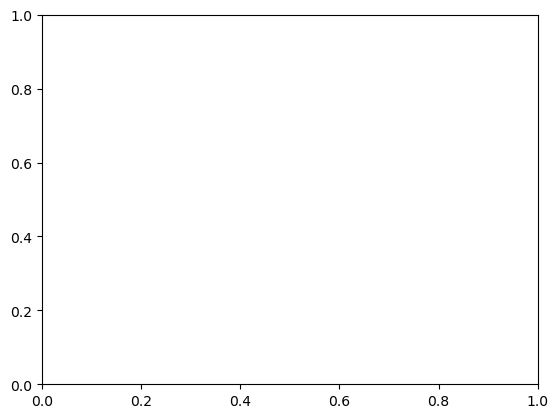

In [20]:
fig, axes = plt.subplots()
vals = mImgGrayScale.mean(axis=0)
# pos: AxesImage = axes.hist(x=mImgGrayScale)
# pos: AxesImage = axes.hist(x=vals)
# plt.colorbar(mappable=pos, ax=axes)
plt.show()

## 4. Steganography

### 4.1 N-Rightmost Bit / Least Significant Bit (LSB):

1. common func:

In [21]:
def calculate_capacity(img: np.ndarray) -> int:
    result: int = img.size - 8
    return result

def get_bit_at(data: bytearray, pos: int) -> int:
    bit_pos = 7 - pos % 8
    # masked: np.uint8 = 1 << bit_pos
    # print(f"mask:{masked:b} data {data[pos//8]:b}")
    return (data[pos//8] >> bit_pos) & 1

def set_bit_at(data: bytearray, pos: int, val: bool) -> bool:
    bit_pos = 7 - pos % 8
    if val:
        masked: np.uint8 = 1 << bit_pos
        data[pos//8] = data[pos//8] | masked
        pass
    else:
        masked: np.uint8 = (~(1 << bit_pos))
        data[pos//8] = data[pos//8] & masked
        pass
    return val

2. hide

In [22]:
data = bytearray(b"this is a secret message")
index = 10
print(f"origin\t\t:{data[1]:08b}")
# print(f"value  :{get_bit_at(data, 10):b}")
# print(f"value at {index}\t:{set_bit_at(data, index, False):b}")
print(f"changed\t\t:{data[1]:08b}")

origin		:01101000
changed		:01101000


In [23]:
def hide_data(img: np.ndarray, data: bytes) -> np.ndarray:
    if calculate_capacity(img=img) < len(data):
        raise Exception("Can not hide data")
    # write the length
    data_len = len(data)
    data_len_bytes = data_len.to_bytes(length=4)
    # print(f"datalen:{data_len}")
    img_shape = img.shape
    index = 0
    result: np.ndarray = mImgGrayScale.copy()
    # print(f"data len bit: {data_len_bytes[3]:032b}")
    # print(f"before: {mImgGrayScale[0][:32]}")
    for index in range(32):
        value_at: bool = get_bit_at(data=data_len_bytes, pos=index)
        result[index//img_shape[0], index%img_shape[1]] >>= 1
        result[index//img_shape[0], index%img_shape[1]] <<= 1
        result[index//img_shape[0], index%img_shape[1]] |= value_at
        pass
    # write the data
    for iBit in range(len(data) * 8):
        bit_val = get_bit_at(data, iBit)
        result[index//img_shape[0], index%img_shape[1]] >>= 1
        result[index//img_shape[0], index%img_shape[1]] <<= 1
        result[index//img_shape[0], index%img_shape[1]] |= bit_val
        index += 1
        pass
    # print(f"after: {result[0][:32]}")
    return result

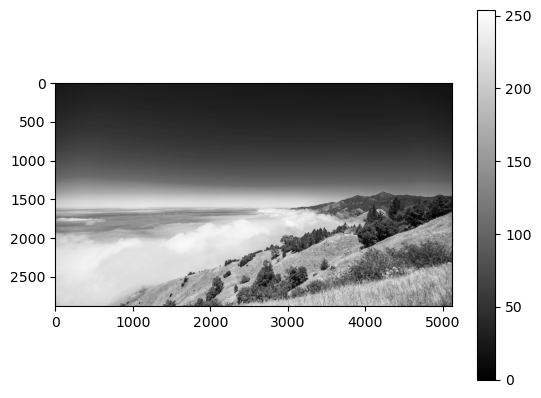

In [24]:
mImgHidden = hide_data(img=mImgGrayScale, data=data)
fig, axes = plt.subplots()
pos: AxesImage = axes.imshow(mImgHidden, cmap="gray")
plt.colorbar(mappable=pos, ax=axes)
plt.show()

3. extract

In [25]:
def extract_data(img: np.ndarray) -> bytearray:
    img_shape = img.shape
    index = 0
    len_val_bytes = bytearray(4)
    for index in range(32):
        val_ = get_bit_at((img[index // img_shape[0], index % img_shape[1]],), 7)
        set_bit_at(len_val_bytes, index, val_)
        pass
    # print(f"lenvar: {len_val_bytes[3]:032b}")
    # print(f"len_val: {int.from_bytes(bytes=len_val_bytes, signed=False)}")
    len_var = int.from_bytes(bytes=len_val_bytes, signed=False)
    result: bytearray = bytearray(len_var)
    for iBit in range(len_var * 8):
        bit_val: bool = get_bit_at((img[index//img_shape[0], index%img_shape[1]],), 7) 
        set_bit_at(data=result, pos=iBit, val=bit_val)
        index += 1
        pass
    return result

In [26]:
data = extract_data(mImgHidden)
print(f"decoded data: {data}")

decoded data: bytearray(b'this is a secret message')


### 4.2 Hamming Code